# Text Mining & Search
Authors
- Alexandre Crivellari
- Andrea Muscio

# Introduction

[TO DO]

# Workspace setting

## Dependencies

In [1]:
# Uncomment if needed to install the required packages

#%pip install pandas numpy matplotlib seaborn scikit-learn
#%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
#%pip install captum

## Libraries

In [27]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import torch.nn.functional as F

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

## Dataset upload and exploration

In [3]:
# Define the column names
columns = ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 
           'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 
           'mostly_true_counts', 'pants_on_fire_counts', 'context']

# Read the TSV files
train_df = pd.read_csv('train.tsv', sep='\t', names=columns)
valid_df = pd.read_csv('valid.tsv', sep='\t', names=columns)
test_df = pd.read_csv('test.tsv', sep='\t', names=columns)

# Display the first few rows of the training data
train_df.head()

,id,label,statement,subject,speaker,job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [4]:
print(train_df.columns)

Index(['id', 'label', 'statement', 'subject', 'speaker', 'job_title',
       'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts',
       'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts',
       'context'],
      dtype='object')


In [5]:
# Check for missing values
print(train_df.isnull().sum())

id                         0
label                      0
statement                  0
subject                    2
speaker                    2
job_title               2898
state_info              2210
party_affiliation          2
barely_true_counts         2
false_counts               2
half_true_counts           2
mostly_true_counts         2
pants_on_fire_counts       2
context                  102
dtype: int64


In [6]:
# TEST REMOVING COLUMNS
# Remove 'job_title' and 'state_info' columns from all datasets
columns_to_remove = ['job_title', 'state_info']

train_df = train_df.drop(columns=columns_to_remove)
valid_df = valid_df.drop(columns=columns_to_remove)
test_df = test_df.drop(columns=columns_to_remove)

# Verify the columns have been removed
print(train_df.columns)

Index(['id', 'label', 'statement', 'subject', 'speaker', 'party_affiliation',
       'barely_true_counts', 'false_counts', 'half_true_counts',
       'mostly_true_counts', 'pants_on_fire_counts', 'context'],
      dtype='object')


id                        0
label                     0
statement                 0
subject                   2
speaker                   2
party_affiliation         2
barely_true_counts        2
false_counts              2
half_true_counts          2
mostly_true_counts        2
pants_on_fire_counts      2
context                 102
dtype: int64
label
half-true      0.206445
false          0.194824
mostly-true    0.191602
true           0.163672
barely-true    0.161523
pants-fire     0.081934
Name: proportion, dtype: float64


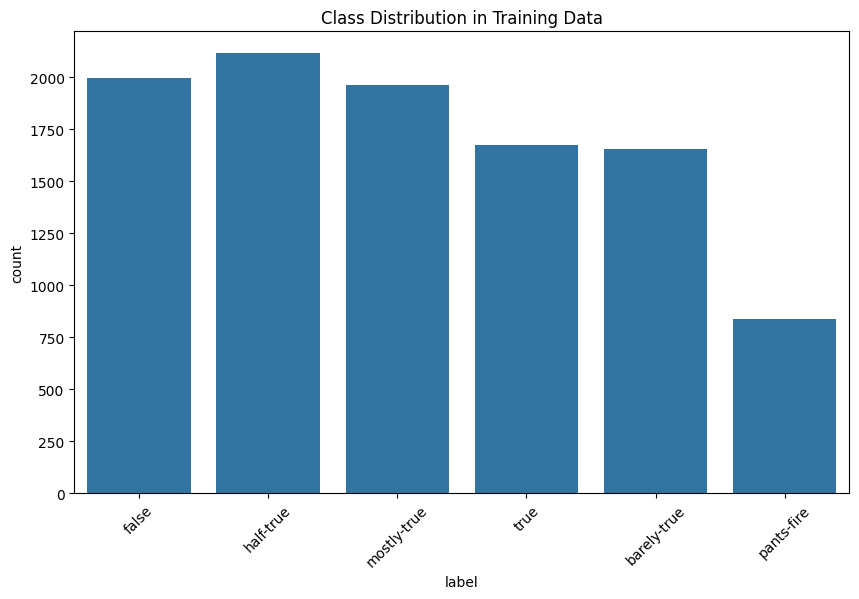

In [7]:
# Check for missing values
print(train_df.isnull().sum())

# Handle missing values (if any)
train_df = train_df.fillna('unknown')
valid_df = valid_df.fillna('unknown')
test_df = test_df.fillna('unknown')

# Handle missing values
categorical_columns = ['subject', 'speaker', 'party_affiliation', 'context']
numeric_columns = ['barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts']

# For categorical columns, fill with 'Unknown' instead of 'unknown'
for col in categorical_columns:
    train_df[col] = train_df[col].fillna('Unknown')
    valid_df[col] = valid_df[col].fillna('Unknown')
    test_df[col] = test_df[col].fillna('Unknown')

# For numeric columns, ensure they are numeric and fill with median
for col in numeric_columns:
    train_df[col] = pd.to_numeric(train_df[col], errors='coerce')
    valid_df[col] = pd.to_numeric(valid_df[col], errors='coerce')
    test_df[col] = pd.to_numeric(test_df[col], errors='coerce')
    
    median_value = train_df[col].median()
    train_df[col] = train_df[col].fillna(median_value)
    valid_df[col] = valid_df[col].fillna(median_value)
    test_df[col] = test_df[col].fillna(median_value)

# Encode labels
le = LabelEncoder()
train_df['label_encoded'] = le.fit_transform(train_df['label'])
valid_df['label_encoded'] = le.transform(valid_df['label'])
test_df['label_encoded'] = le.transform(test_df['label'])

# Display class distribution
print(train_df['label'].value_counts(normalize=True))

# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=train_df)
plt.title('Class Distribution in Training Data')
plt.xticks(rotation=45)
plt.show()

## Feature Engineering

In [8]:
# Step 2: Feature Engineering (updated)

# Create a feature for statement length
train_df['statement_length'] = train_df['statement'].str.len()
valid_df['statement_length'] = valid_df['statement'].str.len()
test_df['statement_length'] = test_df['statement'].str.len()

# Aggregate count features
count_columns = ['barely_true_counts', 'false_counts', 'half_true_counts', 
                 'mostly_true_counts', 'pants_on_fire_counts']

train_df['total_statements'] = train_df[count_columns].sum(axis=1)
valid_df['total_statements'] = valid_df[count_columns].sum(axis=1)
test_df['total_statements'] = test_df[count_columns].sum(axis=1)

# Task 1 - Text Classification (Binary)

More preprocessing

Class distribution in training set:
binary_label
False    0.644727
True     0.355273
Name: proportion, dtype: float64

Class distribution in validation set:
binary_label
False    0.672897
True     0.327103
Name: proportion, dtype: float64

Class distribution in test set:
binary_label
False    0.64562
True     0.35438
Name: proportion, dtype: float64


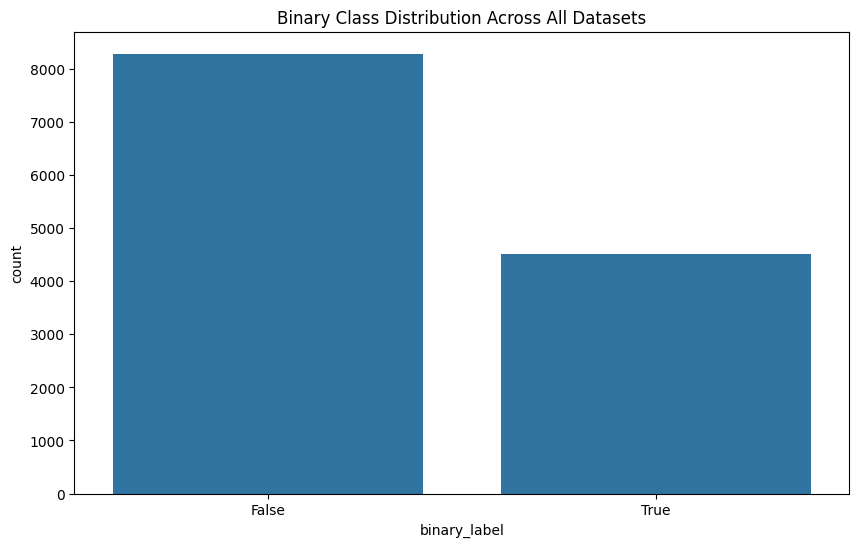

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Assuming you have already loaded your datasets into train_df, valid_df, and test_df

def binarize_labels(label):
    if label in ['true', 'mostly-true']:
        return 'True'
    else:
        return 'False'

# Apply binary labeling to all datasets
train_df['binary_label'] = train_df['label'].apply(binarize_labels)
valid_df['binary_label'] = valid_df['label'].apply(binarize_labels)
test_df['binary_label'] = test_df['label'].apply(binarize_labels)

# Encode binary labels
le = LabelEncoder()
train_df['label_encoded'] = le.fit_transform(train_df['binary_label'])
valid_df['label_encoded'] = le.transform(valid_df['binary_label'])
test_df['label_encoded'] = le.transform(test_df['binary_label'])

# Display class distribution
print("Class distribution in training set:")
print(train_df['binary_label'].value_counts(normalize=True))

print("\nClass distribution in validation set:")
print(valid_df['binary_label'].value_counts(normalize=True))

print("\nClass distribution in test set:")
print(test_df['binary_label'].value_counts(normalize=True))

# Visualize class distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(x='binary_label', data=pd.concat([train_df, valid_df, test_df]))
plt.title('Binary Class Distribution Across All Datasets')
plt.show()

In [10]:
# Print some sample rows to verify the transformation
print("\nSample rows from the training set:")
print(train_df[['statement', 'label', 'binary_label', 'label_encoded']].head(10))


Sample rows from the training set:
                                           statement        label  \
0  Says the Annies List political group supports ...        false   
1  When did the decline of coal start? It started...    half-true   
2  Hillary Clinton agrees with John McCain "by vo...  mostly-true   
3  Health care reform legislation is likely to ma...        false   
4  The economic turnaround started at the end of ...    half-true   
5  The Chicago Bears have had more starting quart...         true   
6  Jim Dunnam has not lived in the district he re...  barely-true   
7  I'm the only person on this stage who has work...    half-true   
8  However, it took $19.5 million in Oregon Lotte...    half-true   
9  Says GOP primary opponents Glenn Grothman and ...  mostly-true   

  binary_label  label_encoded  
0        False              0  
1        False              0  
2         True              1  
3        False              0  
4        False              0  
5         Tr

In [11]:
# Save the label encoder
import joblib
joblib.dump(le, 'binary_label_encoder.joblib')
print("\nLabel Encoder saved as 'binary_label_encoder.joblib'")


Label Encoder saved as 'binary_label_encoder.joblib'


### Traditional ML - Random Forest Classifier

In [12]:
# Text preprocessing function
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove stopwords and lemmatize
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    cleaned_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(cleaned_tokens)

# Apply text preprocessing
train_df['cleaned_statement'] = train_df['statement'].apply(preprocess_text)
valid_df['cleaned_statement'] = valid_df['statement'].apply(preprocess_text)
test_df['cleaned_statement'] = test_df['statement'].apply(preprocess_text)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alexc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alexc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
# Prepare data for Traditional ML (Random Forest)
# TF-IDF Vectorization with a fixed number of features
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(train_df['cleaned_statement'])
X_valid_tfidf = tfidf.transform(valid_df['cleaned_statement'])
X_test_tfidf = tfidf.transform(test_df['cleaned_statement'])

# Prepare numerical features
numerical_features = ['statement_length', 'total_statements', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts']

scaler = StandardScaler()
X_train_num = scaler.fit_transform(train_df[numerical_features])
X_valid_num = scaler.transform(valid_df[numerical_features])
X_test_num = scaler.transform(test_df[numerical_features])

# Combine TF-IDF and numerical features
X_train = np.hstack((X_train_tfidf.toarray(), X_train_num))
X_valid = np.hstack((X_valid_tfidf.toarray(), X_valid_num))
X_test = np.hstack((X_test_tfidf.toarray(), X_test_num))

y_train = train_df['label_encoded']
y_valid = valid_df['label_encoded']
y_test = test_df['label_encoded']

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

c:\Users\alexc\anaconda3\envs\TorchP11\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [14]:
# Train the model
def train_with_progress(X, y, n_estimators=100):
    rf_model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf_model.fit(X, y)
    return rf_model

print("Training Random Forest model...")
rf_model = train_with_progress(X_train_resampled, y_train_resampled)

Training Random Forest model...


In [15]:
# Evaluation function
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    
    results = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC'],
        'Score': [accuracy, precision, recall, f1, auc_roc]
    })
    
    return results, y_pred, y_pred_proba

# Evaluate the model
print("Evaluating the model...")
results, y_pred, y_test_pred = evaluate_model(rf_model, X_test, y_test)
print(results)

# Print feature counts for debugging
print(f"Number of features in training data: {X_train_resampled.shape[1]}")
print(f"Number of features in test data: {X_test.shape[1]}")

Evaluating the model...
      Metric     Score
0   Accuracy  0.726914
1  Precision  0.652819
2     Recall  0.489978
3   F1 Score  0.559796
4    AUC-ROC  0.769109
Number of features in training data: 5007
Number of features in test data: 5007



Generating performance visualizations...


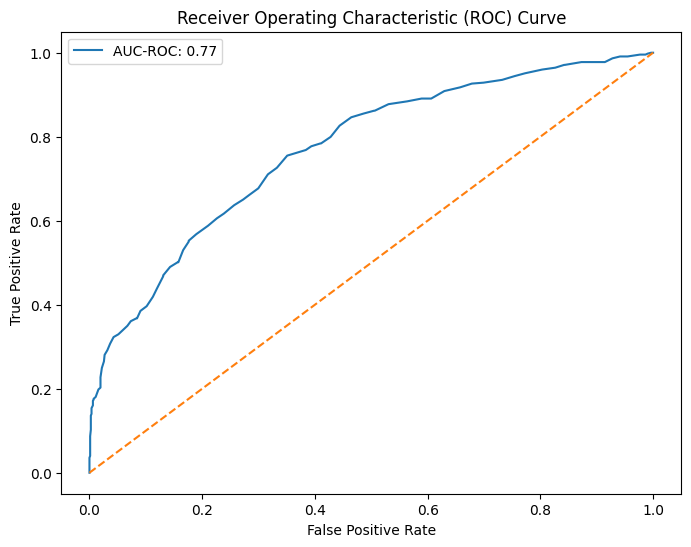

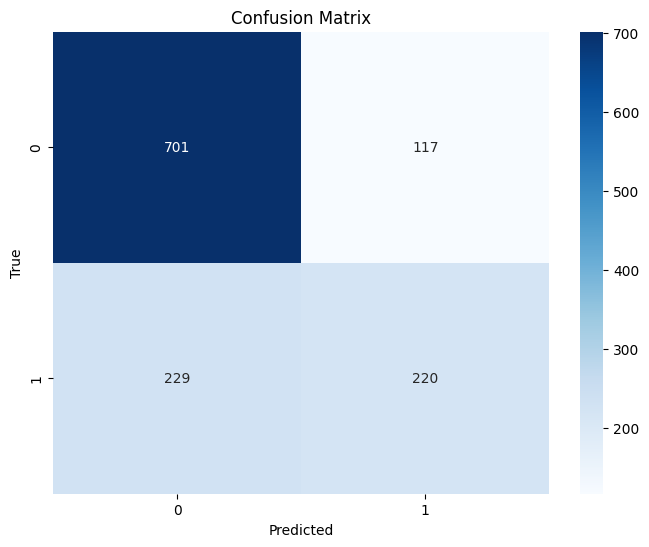

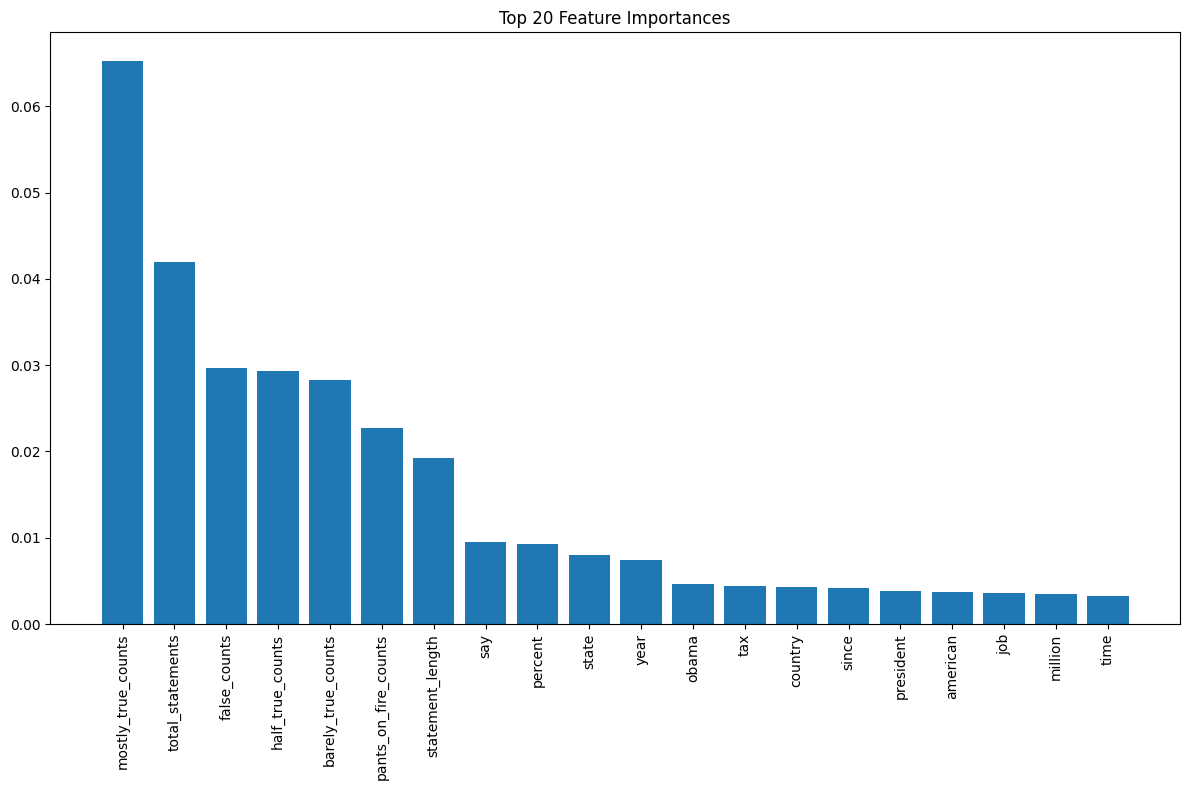

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, confusion_matrix

# ROC Curve
def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC-ROC: {roc_auc_score(y_true, y_pred_proba):.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Feature Importance
def plot_feature_importance(model, feature_names, top_n=20):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:top_n]
    
    plt.figure(figsize=(12, 8))
    plt.title(f"Top {top_n} Feature Importances")
    plt.bar(range(top_n), importances[indices])
    plt.xticks(range(top_n), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

# After model evaluation, add these lines:
print("\nGenerating performance visualizations...")

# Plot ROC curve
plot_roc_curve(y_test, y_test_pred)

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred)

# Plot feature importance
feature_names = tfidf.get_feature_names_out().tolist() + numerical_features
plot_feature_importance(rf_model, feature_names)

In [17]:
import joblib

def save_model(model, filename='random_forest_model.joblib'):
    joblib.dump(model, filename)
    print(f"Model saved as {filename}")

# Save the model
save_model(rf_model)

Model saved as random_forest_model.joblib


### Deep Learning Model: RoBERTa

In [18]:
# Read the TSV files
train_df = pd.read_csv('train.tsv', sep='\t', names=columns)
valid_df = pd.read_csv('valid.tsv', sep='\t', names=columns)
test_df = pd.read_csv('test.tsv', sep='\t', names=columns)

# Step 2: Preprocess the datasets for RoBERTa

def binarize_labels(label):
    if label in ['true', 'mostly-true']:
        return 'True'
    else:
        return 'False'

# Apply binary labeling to all datasets
train_df['binary_label'] = train_df['label'].apply(binarize_labels)
valid_df['binary_label'] = valid_df['label'].apply(binarize_labels)
test_df['binary_label'] = test_df['label'].apply(binarize_labels)

# Encode binary labels
le = LabelEncoder()
train_df['label_encoded'] = le.fit_transform(train_df['binary_label'])
valid_df['label_encoded'] = le.transform(valid_df['binary_label'])
test_df['label_encoded'] = le.transform(test_df['binary_label'])

In [19]:
# Load RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Tokenize and encode the statements
max_length = 128  # You can adjust this based on your data

def encode_statements(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors='pt')

train_encodings = encode_statements(train_df['statement'].tolist())
valid_encodings = encode_statements(valid_df['statement'].tolist())
test_encodings = encode_statements(test_df['statement'].tolist())

# Create PyTorch datasets
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], 
                              torch.tensor(train_df['label_encoded'].tolist()))
valid_dataset = TensorDataset(valid_encodings['input_ids'], valid_encodings['attention_mask'], 
                              torch.tensor(valid_df['label_encoded'].tolist()))
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], 
                             torch.tensor(test_df['label_encoded'].tolist()))

c:\Users\alexc\anaconda3\envs\TorchP11\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [20]:
# Step 3: Train the model

# Set up the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2).to(device)

# Set up the data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Set up the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\alexc\anaconda3\envs\TorchP11\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [32]:
import time

#Handling class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(train_df['label_encoded']), y=train_df['label_encoded'])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Training loop
epochs = 3
for epoch in range(epochs):
    model.train()
    train_loss = 0
    start_time = time.time()
    
    # Create a tqdm progress bar for the training loader
    train_pbar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs} [Train]', 
                      total=len(train_loader), unit='batch')
    
    for batch in train_pbar:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        # Update the progress bar
        elapsed_time = time.time() - start_time
        batch_time = elapsed_time / (train_pbar.n + 1)
        remaining_time = batch_time * (len(train_loader) - train_pbar.n - 1)
        train_pbar.set_postfix({
            'loss': f'{train_loss / (train_pbar.n + 1):.4f}',
            'elapsed': f'{time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}',
            'remaining': f'{time.strftime("%H:%M:%S", time.gmtime(remaining_time))}',
            'total': f'{time.strftime("%H:%M:%S", time.gmtime(elapsed_time + remaining_time))}'
        })
    
    train_pbar.close()
    
    # Validation
    model.eval()
    valid_loss = 0
    valid_pbar = tqdm(valid_loader, desc=f'Epoch {epoch + 1}/{epochs} [Valid]', 
                      total=len(valid_loader), unit='batch')
    
    with torch.no_grad():
        for batch in valid_pbar:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            valid_loss += outputs.loss.item()
            
            # Update the progress bar
            valid_pbar.set_postfix({'loss': f'{valid_loss / (valid_pbar.n + 1):.4f}'})
    
    valid_pbar.close()
    
    print(f'Epoch {epoch + 1}/{epochs}:')
    print(f'Train Loss: {train_loss / len(train_loader):.4f}')
    print(f'Validation Loss: {valid_loss / len(valid_loader):.4f}')
    print(f'Epoch Time: {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')
    print()

print("Training completed!")

Epoch 1/3 [Valid]: 100%|██████████| 81/81 [00:01<00:00, 73.22batch/s, loss=1.0599]


Epoch 1/3:
Train Loss: 0.1362
Validation Loss: 1.0599
Epoch Time: 00:00:53



Epoch 2/3 [Valid]: 100%|██████████| 81/81 [00:01<00:00, 70.80batch/s, loss=1.2423]


Epoch 2/3:
Train Loss: 0.0981
Validation Loss: 1.2423
Epoch Time: 00:00:53



Epoch 3/3 [Valid]: 100%|██████████| 81/81 [00:01<00:00, 70.23batch/s, loss=1.4333]

Epoch 3/3:
Train Loss: 0.0810
Validation Loss: 1.4333
Epoch Time: 00:00:53

Training completed!


In [33]:
# Save the model
torch.save(model.state_dict(), 'roberta_binary_classifier.pt')
print("Model saved as 'roberta_binary_classifier.pt'")

Model saved as 'roberta_binary_classifier.pt'


C:\Users\alexc\AppData\Local\Temp\ipykernel_36096\244060633.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('roberta_binary_classifier.

Test Accuracy: 0.6117
Precision: 0.4587
Recall: 0.5323
F1-score: 0.4928
AUC-ROC: 0.5938


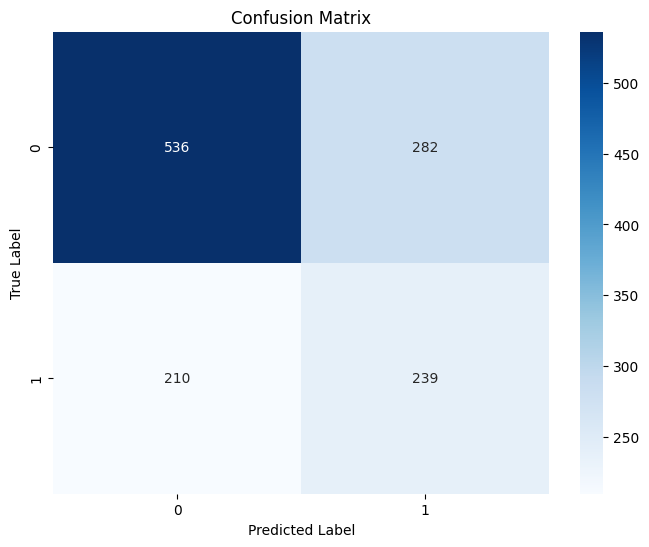

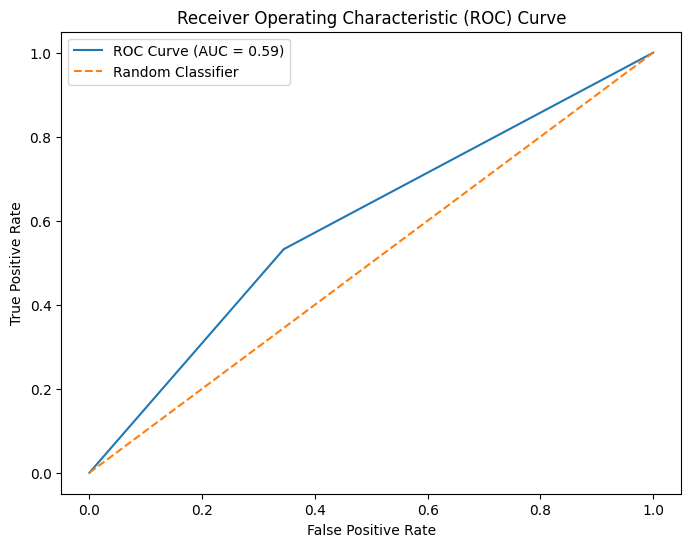

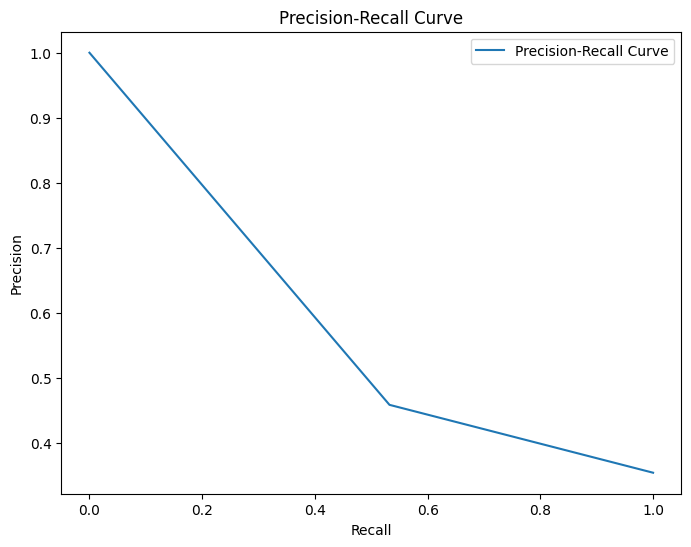

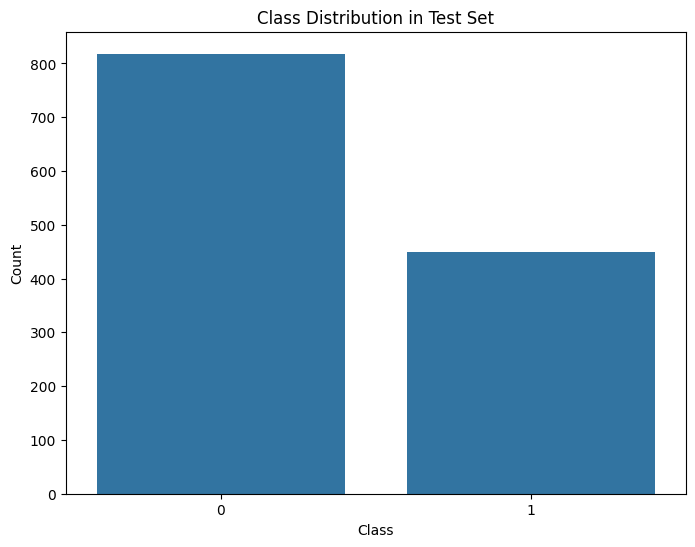

In [34]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# 4. Evaluate the model against the test set

def evaluate_model(model, data_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())
    
    return np.array(predictions), np.array(true_labels)

# Load the saved model
model.load_state_dict(torch.load('roberta_binary_classifier.pt'))
model.to(device)

# Evaluate on test set
test_predictions, test_true_labels = evaluate_model(model, test_loader, device)

# Calculate metrics
accuracy = accuracy_score(test_true_labels, test_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(test_true_labels, test_predictions, average='binary')
auc_roc = roc_auc_score(test_true_labels, test_predictions)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

# 5. Produce graphs for showing model performance

# Confusion Matrix
cm = confusion_matrix(test_true_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(test_true_labels, test_predictions)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_roc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve

precision_curve, recall_curve, _ = precision_recall_curve(test_true_labels, test_predictions)
plt.figure(figsize=(8, 6))
plt.plot(recall_curve, precision_curve, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Class Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=test_true_labels)
plt.title('Class Distribution in Test Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Save the evaluation results
results = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'auc_roc': auc_roc
}

In [31]:
def evaluate_model(model, data_loader, device):
    model.eval()
    all_predictions = []
    all_true_labels = []
    all_probabilities = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probabilities = torch.softmax(logits, dim=1)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_predictions.extend(preds)
            all_true_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities[:, 1].cpu().numpy())
    
    y_pred = np.array(all_predictions)
    y_test = np.array(all_true_labels)
    y_pred_proba = np.array(all_probabilities)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    
    results = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC'],
        'Score': [accuracy, precision, recall, f1, auc_roc]
    })
    
    return results, y_pred, y_pred_proba

# Load the saved model
model.load_state_dict(torch.load('roberta_binary_classifier.pt'))
model.to(device)

# Evaluate the model
print("Evaluating the RoBERTa model...")
results, y_pred, y_test_pred = evaluate_model(model, test_loader, device)
print(results)

C:\Users\alexc\AppData\Local\Temp\ipykernel_36096\1573148793.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('roberta_binary_classifier

Evaluating the RoBERTa model...


Evaluating: 100%|██████████| 80/80 [00:01<00:00, 45.42it/s]

      Metric     Score
0   Accuracy  0.607735
1  Precision  0.455720
2     Recall  0.550111
3   F1 Score  0.498486
4    AUC-ROC  0.641709


# ANDREA CONTINUA DA QUI

# (Task 2) Topic Modelling

Usiamo LDA direi?